In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from IPython.display import Image
InteractiveShell.ast_node_interactivity = "all"
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from IPython.core.interactiveshell import InteractiveShell # multipl outputs in same cells
%config InlineBackend.figure_format = 'retina' # much faster than svg when generating lots of points

%run featimp

# Feature Selection

Feature selection is very important in ML pipline. We meed to consider which features we should included in model training. with too many feature ML models results usually suffer from codependecy, and overfitting issues. So we need feature selection.

- Feature Selection can be treated as a way of regularizatio in order to prevent overfitting, as well as reducing the time to fitting the model and getting rid of redundancy inside the model
- There're loosely 4 big types of ways for feature selection Wrapper Methods, Filter methods, Embedded Methods, and dimension reduction

# Data: Rental Listing Inquiries

data: https://www.kaggle.com/c/two-sigma-connect-rental-listing-inquiries/data

Data fields
- bathrooms: number of bathrooms
- bedrooms: number of bathrooms
- building_id
- created
- description
- display_address
- features: a list of features about this apartment
- latitude
- listing_id
- longitude
- manager_id
- photos: a list of photo links. You are welcome to download the pictures yourselves from renthop's site, but they are the same as imgs.zip. 
- price: in USD
- street_address
- interest_level: this is the target variable. It has 3 categories: 'high', 'medium', 'low'




i will remove any text data related data, id data for the convenience for feature selection, and add two random columns just for experinments

In [15]:
raw = pd.read_json('data/train.json')
df = raw[["bathrooms", "bedrooms", "latitude", "longitude", "interest_level", "price"]]

ordinalencoder = OrdinalEncoder()
df["interest_level"] = ordinalencoder.fit_transform(df[['interest_level']])
df["random_num"]  = np.random.random(size=df.shape[0])
df["random_cat"]  = np.random.randint(0, 10, size = df.shape[0])
X_train, y_train = df.drop('price',axis=1), df['price']

df.head()

,bathrooms,bedrooms,latitude,longitude,interest_level,price,random_num,random_cat
4,1.0,1,40.7108,-73.9539,2.0,2400,0.667597,3
6,1.0,2,40.7513,-73.9722,1.0,3800,0.417178,8
9,1.0,2,40.7575,-73.9625,2.0,3495,0.484695,8
10,1.5,3,40.7145,-73.9425,2.0,3000,0.977242,9
15,1.0,0,40.7439,-73.9743,1.0,2795,0.449255,8


# 1. Wrapper Methods
Wrapper methods need to try out every each subset of the features inside the data,  and pick the subset that satisfies some criterias. and this means normally speaking wrapper methods will takes long time to compute, 
since we need to fitting lots of models. And it used to be a popular way to do feature selection in the traditional statitics. Usually gives better resukts but extremely costly (no free lunch theorom)

- Exhaustive Feature Search (extremely costly try every possible comb and fit models find the feature subset with highest metrics, similar to column drop imprtance)
- Step Forward Feature Selection
- Backward feature Selection

## Backward Feature Selection

Since Exhasutive feature selection is really costly to run. I need some more smarter way to do it. Backward selection helps fit the model with all the features, and sequentially drop features according to some criteria. In this case we use R^2. While forward methods is the opposite: we start by only fitting one feature and then sequentially adding more features. Since the procedures are in different, forward and backward methods might output different results.

Here I just go through the example of backward methods as we can see below the performance goes down as the fifth features kicks in. Also bedroom, latitude, longitude, and interest level are inlcuded which makes sense. The two random columns're not selected which is good

In [36]:
sfs = SFS(RandomForestRegressor(n_estimators=10, random_state=0, n_jobs = -1),
         k_features = 4,
          forward= False,
          floating = False,
          verbose= 1,
          scoring= 'r2',
          cv = 4,
          n_jobs= -1
         ).fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    1.9s finished
Features: 6/4[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed:    1.3s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    1.6s finished
Features: 5/4[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.9s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished
Features: 4/4

('bedrooms', 'latitude', 'longitude', 'interest_level')

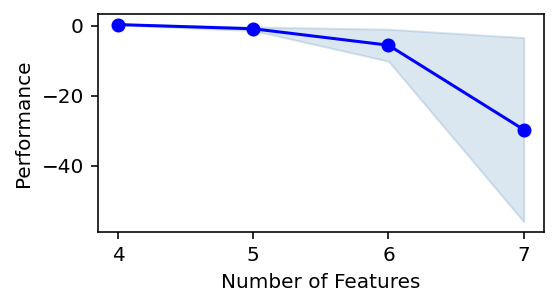

In [48]:
plt.rcParams["figure.figsize"] = (4,2)
fig = plot_sfs(sfs.get_metric_dict(), kind='std_err')
sfs.k_feature_names_

# 2. Filters Methods

Filters based is basically trying to retain the features are useful for modell prediction, and remove the onnes that're are unlikely to be useful (below certain threhold). It is much less computational expensive than
Wrapper since filters methods no need model fitting


- Ranked Correlation Coefficient (Pick Top K features with K highest value of R^2 with response variable. Also called relevance)
- Minimal-redundancy-maximal-relevance

## Ranked Correlation coefficient

The simplest technique to identify important regression features is to rank them by their Spearman's rank correlation coefficient; the feature with the largest coefficient is taken to be the most important. This method is measuring single-feature relevance importance and works well for independent features, but suffers in the presence of codependent features. Groups of features with similar relationships to the response variable receive the same or similar ranks, even though just one should be considered important.


This feature selection scheme selects the features based on the highest correlation to the target variable. This is a straightforward approach but has drawbacks. Due to the high degree of correlation, it might happen that the features itself have a high correlation among them. I.e. in the worst case there exists one feature which can explain (or already determine) all the other features (for instance by a simple linear combination) and makes them obsolete. This results in a high redundancy among the features.


Here ranked cprrelation coefficient suggests bathrooms and bedrooms. But longitude, latitude are not selected

In [16]:
feature_names = df.corr()["price"].sort_values(ascending=False).index[1:]
importances = list(df.corr()["price"].sort_values(ascending=False)[1:])

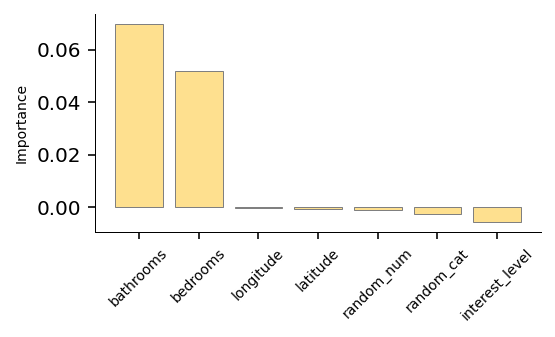

In [17]:
imp_plot(feature_names, importances)

## The Maximum Relevance (correlation): 

This feature selection scheme selects the features based on the highest correlation to the target variable. This is a straightforward approach but has drawbacks. Due to the high degree of correlation, it might happen that the features itself have a high correlation among them. I.e. in the worst case there exists one feature which can explain (or already determine) all the other features (for instance by a simple linear combination) and makes them obsolete. This results in a high redundancy among the features.


## Minimum Redundancy Maximum Relevance

The Maximum Relevance (correlation): This feature selection scheme selects the features based on the highest correlation to the target variable. This is a straightforward approach but has drawbacks. Due to the high degree of correlation, it might happen that the features itself have a high correlation among them. I.e. in the worst case there exists one feature which can explain (or already determine) all the other features (for instance by a simple linear combination) and makes them obsolete. This results in a high redundancy among the features.


This feature selection aims for the selection of features showing low correlations among the features (Minimum Redundancy) but still having a high correlation to the classification variable (Maximum Relevance). For the function 'I' below, we can choose any assoication functions like spearman correlation or f-test;


Some Useful resources: 

1. https://towardsdatascience.com/mrmr-explained-exactly-how-you-wished-someone-explained-to-you-9cf4ed27458b

2. https://arxiv.org/pdf/1908.05376.pdf

3. http://home.penglab.com/papersall/docpdf/2005_TPAMI_FeaSel.pdf


In [188]:
Image(url = "image/mRMR.png")

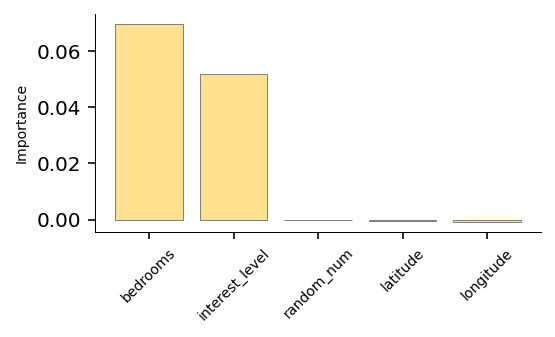

In [20]:
feature_names, importance = mrmr(X_train, y_train, k=5)
imp_plot(feature_names, importances,std=None)

# Embedded Methods

Embedded methods is basically model based methods: feature selection procedure is inherited inside the model
- Decision Tree (Random forest importance)
- Permutation Importance
- Drop columns Importance

## Random forest Feature Importance

Importance in the random forest is calculate by using Gini Drop (classification) or MSE drop (regression);
It will track the loss function drop for each features across the decision nodes, and take average of them; the features with highest
Loss function drop will be one with highest Importance.

Be more sepcific, the decrease in loss function is weighted by the probability of reaching that node. The node probability can be calculated by the number of samples that reach the node, divided by the total number of samples. The higher the value the more important the feature.


However there's a issue with RF importance, that is, it is biased; when one single tree_i exhaustively search the value of featurej to find the split spot, there're will be a high probability that we find a spot that happened to predict the y even though the feature is pure random value; and smae thing for the other trees, and therefore infate the the overall imprtance. that's why ehy implement random forest, we avoid exhuastively search split rather we random;y pick 10 or 15 split to calculate the loss.

Please check this: https://explained.ai/rf-importance/index.html out for more detals (highly recommended)


RandomForestRegressor(n_jobs=-1, oob_score=True)

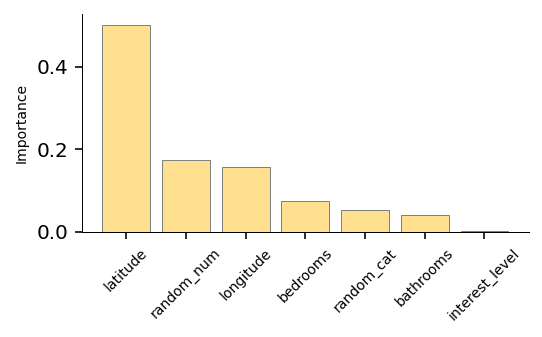

In [50]:
rf = RandomForestRegressor(
         n_estimators=100,
         min_samples_leaf=1,
         n_jobs=-1,
         oob_score=True)
rf.fit(X_train, y_train)

# getting rf imprtance and feature names
importances = rf.feature_importances_
feature_names = X_train.columns
std = np.std([
    tree.feature_importances_ for tree in rf.estimators_], axis=0)

imp_plot(feature_names, importances,std=None)

what we can see above is that the two random columns is more important than all other feautre except the latitude, which does not make sense; As we discusssed above, this might be due to the biased random forest imprtances; A way to improve it is that we need to include the stanard deviation of feature importance

## Random Forest Feature Imprtance with Std

We now use the Imprtance from different trees and calculate the standard deviation of the overall feature importance;

Like we see below, random_cat is being exludeded since it has large variance and likely to be zero; However, random_num is not exludeded, so the bias still exits
So In this case, we can only inlcude latitude, longitude to predict the rent price of the house

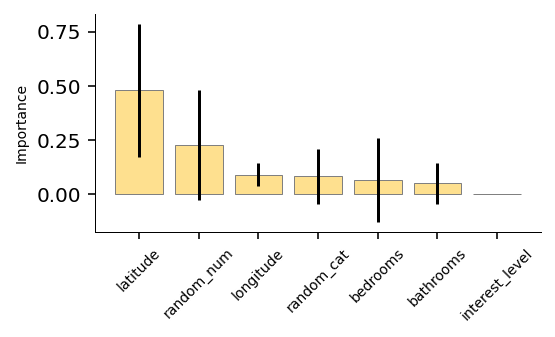

In [190]:
imp_plot(feature_names, importances,std)

## Permutation Importance

By randomly permuting the predictor variable X j (shuffle the value within X_j), its original association with the response Y is broken, but the distribution stil mantained. When the permuted variable X j , together with the remaining unpermuted predictor variables, is used to predict the response, the prediction accuracy (i.e. the number of observations classified correctly) decreases substantially, if the original variable X j was associated with the response. TThen we calculate prediction accuracy before and after permuting X j .

In [96]:
imp = permutation_importances(rf, X_train, y_train,
                              oob_regression_r2_score)

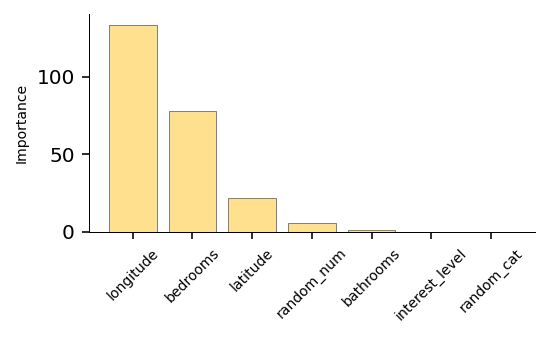

In [97]:
feature_names, importances = list(imp.index), imp.Importance
imp_plot(feature_names, importances,std=None)

## Column Drop Importance

Columnn Drop Importance is very costly as we discuessed already. Instead of inlcuding features each time like exhuastive search, column-drop drop columns, and retrain the model each time to find the feature combination with the highest importance

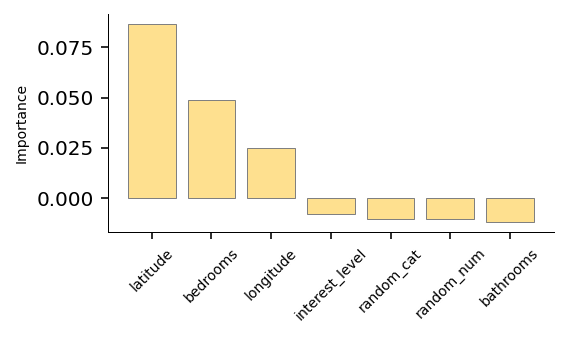

In [99]:
imp = dropcol_importances(rf, X_train, y_train)
feature_names, importances = list(imp.index), imp.Importance
imp_plot(feature_names, importances,std=None)

# Dimension Reduction Methods

PCA is another way we can do feature selection; Notice that this is original 7 features are being transformed into new space with eigen vector and eigen value
we can then calculate the cumulative variance for new transformed feature, to determine the important component. For the figure below, variable_1, 2 and 3 take the
majority of variance of the data. So that we can exclude other features in this case.

PCA(n_components=7)

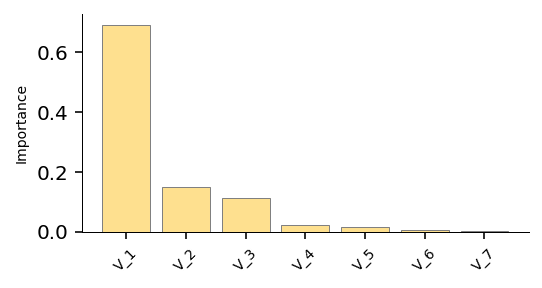

In [239]:
from sklearn.decomposition import PCA
pca = PCA(n_components=X_train.shape[1])
pca.fit(X_train)
importance = pca.explained_variance_ratio_
feature_names = [f'V_{i+1}'  for i in range(7)]

imp_plot(feature_names, importance)

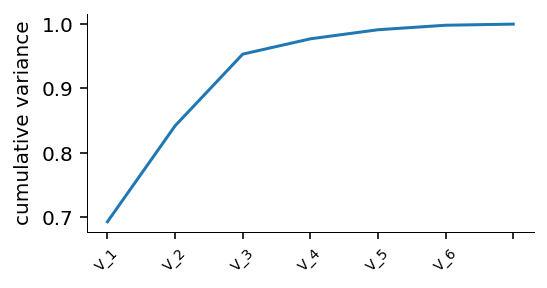

In [238]:
pca_var_plot(feature_names=feature_names, data=X_train)
